# Feature Modeling

This notebook will have an ensemble method composed of ridge linear regression, desicion tree regression, and XGBoost regression in order to predict Airbnb price listings for rentals.

In [5]:
# Importing libraries
import numpy as np
import pandas as pd
from tabulate import tabulate
import sklearn as skl
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import (
    LinearRegression, Ridge, Lasso, ElasticNet
)
from xgboost import XGBClassifier, XGBRegressor
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report

import matplotlib as mpl
import matplotlib.pyplot as plt

# Make this notebook's output stable across runs
random_seed = np.random.seed(100)

# NC
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
import xgboost as xgb

from ipylab import JupyterFrontEnd

# Data Cleanup

In [6]:
# Reading in the data
df = pd.read_csv('../listings.csv', low_memory=False)

In [7]:
df.shape

(216313, 22)

In [8]:
df.head()

,ID,Name,Host_ID,Host_Name,Neighborhood_Group,Neighbourhood,Latitude,Longitude,Room_Type,Price,...,Last_Review,Reviews_per_Month,Calculated_Host_Listings_Count,Availability_365,Number_of_Reviews_LTM,Llicense,City,State,MedianIncome,MedianAge
0,108061,Walk to stores/parks/downtown. Fenced yard/Pet...,320564,Lisa,NaN,28801,35.60670,-82.55563,Entire home/apt,120,...,11/30/2019,0.71,2,344,0,NaN,Asheville,NC,49809,39.0
1,155305,Cottage! BonPaul + Sharky's Hostel,746673,BonPaul,NaN,28806,35.57864,-82.59578,Entire home/apt,90,...,12/5/2021,2.75,7,244,68,NaN,Asheville,NC,49809,39.0
2,156805,"Private Room ""Ader"" at BPS Hostel",746673,BonPaul,NaN,28806,35.57864,-82.59578,Private room,66,...,1/1/2020,0.54,7,0,0,NaN,Asheville,NC,49809,39.0
3,156926,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",746673,BonPaul,NaN,28806,35.57864,-82.59578,Shared room,33,...,11/14/2021,2.36,7,262,15,NaN,Asheville,NC,49809,39.0
4,160594,Historic Grove Park,769252,Elizabeth,NaN,28801,35.61442,-82.54127,Private room,125,...,10/19/2015,0.46,1,0,0,NaN,Asheville,NC,49809,39.0


In [9]:
# Not sure which columns to drop
df = df.drop(labels = ['ID', 'Name', 'Host_ID', 'Host_Name',
                       'Last_Review', 'Llicense'],
             axis=1)

In [10]:
df.columns

Index(['Neighborhood_Group', 'Neighbourhood', 'Latitude', 'Longitude',
       'Room_Type', 'Price', 'Minimum_Nights', 'Number_of_Reviews',
       'Reviews_per_Month', 'Calculated_Host_Listings_Count',
       'Availability_365', 'Number_of_Reviews_LTM', 'City', 'State',
       'MedianIncome', 'MedianAge'],
      dtype='object')

In [11]:
# Replace Median Income numbers with commons to integers
df['MedianIncome'] = df['MedianIncome'].str.replace(',','')
df['MedianIncome'] = df['MedianIncome'].astype('int64')

In [12]:
df['Price'].describe()

count    216313.000000
mean        252.771821
std         637.852134
min           0.000000
25%          89.000000
50%         147.000000
75%         250.000000
max       25000.000000
Name: Price, dtype: float64

In [13]:
# Keep only strictly positive prices in a reasonable range
df = df[df['Price'] > 0]
df = df[df['Price'] < 10000]

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

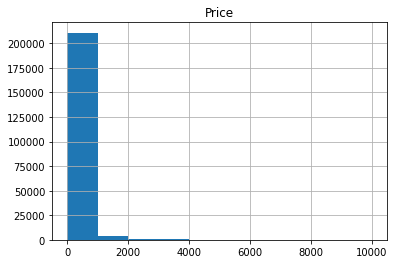

In [14]:
df.hist('Price')

In [15]:
df['logPrice'] = np.log(df['Price'])

array([[<AxesSubplot:title={'center':'logPrice'}>]], dtype=object)

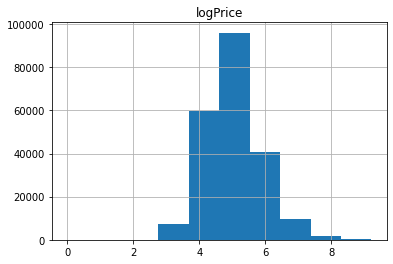

In [16]:
# Can be easier for linear models to fit log in cases of skew
# Useful for linreg, etc.
df.hist('logPrice')

In [17]:
# Drop missing
df = df.dropna(axis=0, how='any')

In [18]:
# Splitting up the data for train and test split
X = df.drop(['Price', 'logPrice'], axis=1)
y = df['logPrice']

num_vars = ['Latitude', 'Longitude', 'Minimum_Nights', 'Number_of_Reviews',
            'Reviews_per_Month', 'Calculated_Host_Listings_Count',
            'Availability_365', 'Number_of_Reviews_LTM', 'MedianIncome',
            'MedianAge']

cat_vars = list(set(X.columns) - set(num_vars))

coltrans = ColumnTransformer([
    ('numerical', StandardScaler(), num_vars),
    ('categorical', OneHotEncoder(sparse=False, drop='first'), cat_vars),
])

X_trans = coltrans.fit_transform(X)

# Use PCA to decrease dimensionality
pca = PCA(n_components=.99)
X_pca = pca.fit_transform(X_trans)

In [19]:
# Initial rows and columns
X_trans.shape

(80653, 687)

In [20]:
# New rows and columns
X_pca.shape

(80653, 211)

In [21]:
# Doing the train test split
(X_train, X_test,
 y_train, y_test) = train_test_split(X_pca, y, test_size=0.2,
                                     random_state=random_seed)

## XGBoost

In [ ]:
# Create an XGBoost classifier and fit to training data
# This takes a while to run

# See below for loading a saved model

search_params = {
    'n_estimators':range(300, 600, 100),
    'lambda': np.arange(0, 1.2, 0.4),
    'max_depth':range(3, 6),
    'colsample_bytree':[0.5, 0.75, 1]
}

xgbreg = XGBRegressor()

xgbreg_grid = GridSearchCV(xgbreg, search_params)
xgbreg_grid.fit(X_train, y_train)

xgbreg = xgbreg_grid.best_estimator_
xgbreg.save_model('xgbmodel.json')
xgbreg_grid.best_params_

In [17]:
# Load a saved xgboost model
xgbreg = XGBRegressor()
xgbreg.load_model('xgbmodel.json')

In [18]:
# Evaluate on training data
y_pred = xgbreg.predict(X_train)
print('Training Dataset R2: ', round(r2_score(y_train, y_pred),2))

Training Dataset R2:  0.73


In [19]:
# Evaluate on testing data
y_test_pred = xgbreg.predict(X_test)
print('Testing Dataset R2: ', round(r2_score(y_test, y_test_pred),2))

Testing Dataset R2:  0.58


In [20]:
np.sqrt(mean_squared_error(y_test, y_test_pred))

0.5173627616470474

In [21]:
# Automatically save the notebook after compute
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

# Linear Regression

In [23]:
# Define functions
lin_reg = LinearRegression()
ridge = Ridge(tol=.001)
lass = Lasso(tol=0.05)
elastic_net = ElasticNet(tol=0.05)

In [23]:
# do Linear Regression
lin_reg_fit = lin_reg.fit(X_train, y_train)
y_pred = lin_reg_fit.predict(X_test)
print("\n Linear Regression: " + str(round(r2_score(y_test, y_pred),2)))


 Linear Regression: 0.47


In [29]:
# do param_grid for Ridge
ridge_grid = GridSearchCV(ridge, param_grid={'alpha': [0.01, 0.25, 0.30, 0.40, 0.5, 1, 1.5, 2, 3, 4, 5]}, scoring='r2')
ridge_fit = ridge_grid.fit(X_train, y_train)
print("\n RIDGE: The best score across ALL searched params:\n", round(ridge_grid.best_score_, 2))
print("\n RIDGE: The best parameters across ALL searched params:\n", ridge_grid.best_params_)


 RIDGE: The best score across ALL searched params:
 0.48

 RIDGE: The best parameters across ALL searched params:
 {'alpha': 4}


In [32]:
# see how well the ridge linear regression generalizes on testing data
y_pred = ridge_fit.predict(X_test)
print("Testing Dataset Accuracy: ", round(r2_score(y_test, y_pred),2))

Testing Dataset Accuracy:  0.47


In [25]:
# do param_grid for Lasso
lasso_grid = GridSearchCV(ridge, param_grid={'alpha' : [0.01, 0.25, 0.50, 0.75, 1, 1.5, 2, 3, 4, 5]}, scoring='r2')
lasso_fit = lasso_grid.fit(X_train, y_train)
print("\n LASSO: The best score across ALL searched params:\n", round(lasso_grid.best_score_,2))
print("\n LASSO: The best parameters across ALL searched params:\n", lasso_grid.best_params_)


 LASSO: The best score across ALL searched params:
 0.48

 LASSO: The best parameters across ALL searched params:
 {'alpha': 4}


# Decision Tree Regression

In [26]:
tree_reg = DecisionTreeRegressor(max_depth=10, random_state=random_seed)
tree_reg.fit(X_train, y_train)

# Evaluate on testing data
y_pred = tree_reg.predict(X_train)
print("Training Dataset Accuracy: ", round(r2_score(y_train, y_pred),2))

Training Dataset Accuracy:  0.57


In [27]:
# Evaluate on training data
y_train_pred = tree_reg.predict(X_train)
print("Training Dataset Accuracy: ", round(r2_score(y_train, y_train_pred),2))

Training Dataset Accuracy:  0.57


In [28]:
# Evaluate on testing data
y_test_pred = tree_reg.predict(X_test)
print("Testing Dataset Accuracy: ", round(r2_score(y_test, y_test_pred),2))

Testing Dataset Accuracy:  0.5


# Voting Regressor

In [29]:
voting_reg = VotingRegressor(
    estimators=[('ridge', ridge_grid), ('tree', tree_reg),
                ('xbg', xgbreg)])

In [30]:
# Evaluate voting regressor on the training data
voting_reg.fit(X_train, y_train)
y_pred = voting_reg.predict(X_train)
print("Training Dataset Accuracy: ", round(r2_score(y_train, y_pred,),2))

Training Dataset Accuracy:  0.64


In [31]:
for reg in voting_reg.estimators_:
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_test)
    print('{:<24} {:.3f}'.format(reg.__class__.__name__,
                                 r2_score(y_test, y_pred)))

GridSearchCV             0.466
DecisionTreeRegressor    0.497
XGBRegressor             0.582


In [32]:
# Evaluate voting regressor on testing data
y_test_pred = voting_reg.predict(X_test)
print("Testing Dataset Accuracy: ", round(r2_score(y_test, y_test_pred,),2))

Testing Dataset Accuracy:  0.56


In [33]:
# Automatically save the notebook after compute
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')

# Tweaking Price Prediction for Airbnb Usage

In [34]:
# Fitting a 5% increase to the price.

# Changing logprice to regular price
y_pred = np.exp(y_test_pred)

# Add a 5% increase to all the predicted values
y_pred_inflated = y_pred * 1.05

# Validating if that worked
print(f'Prediction Validation: ${y_pred[0]: .2f}')
print(f'\nPrediction Inflated: ${y_pred_inflated[0]: .2f}')

# Rounding to the nearest whole number
pred_round_to_whole_num = [round(num, 0) for num in y_pred_inflated]

# Validating if rounding worked
print(f'\nFinal Price Prediction for First Instance in Test: ${pred_round_to_whole_num[0]: .2f}')

Prediction Validation: $ 175.88

Prediction Inflated: $ 184.67

Final Price Prediction for First Instance in Test: $ 185.00


In [35]:
# Automatically save the notebook after compute
app = JupyterFrontEnd()
app.commands.execute('docmanager:save')